In [ ]:
import pandas as pd

# 檔案路徑
downloaded_path = "/mnt/d/Download/91APP_Dataset(會員&主單&子單&商品頁&標籤)/Order_TS.csv"
output_path = "/mnt/d/Download/91APP_Dataset(會員&主單&子單&商品頁&標籤)/filtered_orders_2023Q4.csv"

# 日期過濾條件
start_date = pd.to_datetime("2023-09-01")
end_date = pd.to_datetime("2023-12-31")

# 分批處理設定
chunksize = 100_000  # 每次處理 10 萬筆
filtered_chunks = []  # 儲存過濾後的區塊

# 開始分批讀取處理
for chunk in pd.read_csv(downloaded_path, encoding='utf-8-sig', chunksize=chunksize, low_memory=False):
    # 確保日期欄轉成 datetime 格式
    chunk['OrderDateTime'] = pd.to_datetime(chunk['OrderDateTime'], errors='coerce')

    # 篩選條件
    mask = (chunk['OrderDateTime'] >= start_date) & (chunk['OrderDateTime'] <= end_date)
    filtered_chunk = chunk[mask]

    # 若這個區塊有符合資料，就加進去
    if not filtered_chunk.empty:
        filtered_chunks.append(filtered_chunk)

# 合併所有過濾後的區塊
if filtered_chunks:
    result_df = pd.concat(filtered_chunks, ignore_index=True)
    # 儲存為 CSV（可以處理百萬筆）
    result_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"✅ 篩選完成，共 {len(result_df):,} 筆資料已儲存為 CSV：\n{output_path}")
else:
    print("⚠️ 沒有符合條件的資料。")


/tmp/ipykernel_2952/4270544985.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk['OrderDateTime'] = pd.to_datetime(chunk['OrderDateTime'], errors='coerce')
/tmp/ipykernel_2952/4270544985.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk['OrderDateTime'] = pd.to_datetime(chunk['OrderDateTime'], errors='coerce')
/tmp/ipykernel_2952/4270544985.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk['OrderDateTime'] = pd.to_datetime(chunk['OrderDateTime'], errors='coerce')


✅ 篩選完成，共 7,389,098 筆資料已儲存為 CSV：
/mnt/d/Download/91APP_Dataset(會員&主單&子單&商品頁&標籤)/filtered_orders_2023Q4.csv


In [ ]:
# 依 ProductSkuCode 統計銷售次數
product_counts = (
    result_df.groupby('ProductSkuCode')
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

# 顯示前 10 名商品
print("2023/9~12 熱銷商品前 10 名：")
print(product_counts.head(10))

# 計算唯一商品數量
unique_product_count = result_df['ProductSkuCode'].nunique()
print(f"\n在 2023/9~12 出現的不同商品數量（unique ProductSkuCode）為：{unique_product_count}")


2023/9~12 熱銷商品前 10 名：
                 ProductSkuCode  count
36092  wyZkg0h1raWTdmBVvc8o3g==  74477
35840  wXrQEqRaVQrSdDCa3SETaA==  22382
37390  z6R0quznLdkwoa6nNbW/Ag==  17694
2899   2su0geveaBsbtOF1i5CGIQ==  15810
19646  UwkueebaxP79SBHsasaiHQ==  14322
6809   9GFNE9saToUlOwvhaL2OmQ==  13307
19235  UFhwFfYbmFxHpwFk9U6ELw==  13041
36779  y2hk03fgYcNKD997lTqaaQ==  13013
29664  m/gNuAlj1NfEse4gdk/8Jw==  12373
5939   7rA/IDUAwi10Y7rHX2hbdw==  11786

在 2023/9~12 出現的不同商品數量（unique ProductSkuCode）為：37909


In [ ]:
#將SalePage加入分類
#對每筆 SalePageTitle 做中文斷詞與 TF-IDF 轉換，來找出能代表商品的關鍵詞。
#分群（KMeans 聚類）將 TF-IDF 向量進行分群，可將商品自動分為 N 類。
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import chardet
import os

# === 1. 指定檔案路徑 ===
input_path = "/mnt/d/Download/91APP_Dataset(會員&主單&子單&商品頁&標籤)/SalePage.csv"

# === 3. 讀取 CSV（以偵測到的編碼）===
df = pd.read_csv(input_path, encoding = "ISO-8859-1")
print(f"📦 原始資料筆數：{len(df)}")

# === 4. 對 SalePageTitle 欄位進行 TF-IDF 轉換 ===
titles = df['SalePageTitle'].fillna("").tolist()
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(titles)

# === 5. KMeans 分群 ===
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(X)
df['CategoryCluster'] = clusters

# === 6. 儲存結果為新的 CSV（UTF-8）===
output_path = input_path.replace(".csv", "_withCluster.csv")
df.to_csv(output_path, index=False, encoding = "ISO-8859-1")

print(f"✅ 分群完成，結果儲存為：{output_path}")

🔍 偵測到編碼：Big5
📦 原始資料筆數：72734
✅ 分群完成，結果儲存為：/mnt/d/Download/91APP_Dataset(會員&主單&子單&商品頁&標籤)/SalePage_withCluster.csv


In [ ]:
!pip install jieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 53.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314507 sha256=49bf0003219bb82b184042246201818f174836f1becff505e55ee504fc0d354c
  Stored in directory: /home/userx/.cache/pip/wheels/08/a1/a3/5c8ac52cc2f5782ffffc34c95c57c8e5ecb3063dc69541ee7c
Successfully built jieba


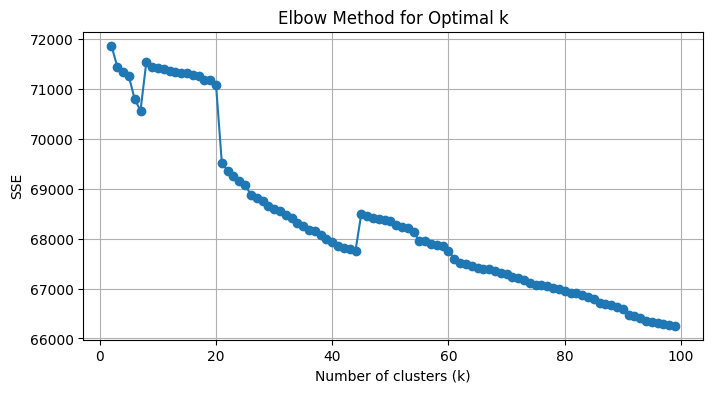

✅ 已成功輸出結果至：/mnt/d/Download/91APP_Dataset(會員&主單&子單&商品頁&標籤)/SalePage_with_category.xlsx


In [ ]:
import pandas as pd
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import display
import io

# === 1. 讀取原始資料（含亂碼處理）===
input_path = "/mnt/d/Download/91APP_Dataset(會員&主單&子單&商品頁&標籤)/SalePage.csv"
df = pd.read_csv(input_path, encoding='ISO-8859-1')

# 修復 Big5 亂碼 → 正常中文
def fix_encoding(text):
    try:
        return text.encode('ISO-8859-1').decode('big5')
    except:
        return text

df['SalePageTitle'] = df['SalePageTitle'].astype(str).apply(fix_encoding)
df['SaleProductDescShortContent'] = df['SaleProductDescShortContent'].astype(str).apply(fix_encoding)


# === 2. 中文斷詞 + TF-IDF ===
titles_cut = [" ".join(jieba.cut(t)) for t in df['SalePageTitle'].fillna("")]

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5)
X = vectorizer.fit_transform(titles_cut)

# === 3. 肘部法決定最佳群數（這裡你可畫圖手動觀察）===
sse = []
K_range = range(2, 100)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, sse, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

# === 4. 套用最佳 k 值，進行分群 ===
best_k = 100  # ← 自行根據肘部圖決定
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['category'] = kmeans.fit_predict(X)  # 直接用你要的欄位名 "category"

# === 5. 存入新的 Excel（保留原始資料 + 新欄位 category）===
output_path = input_path.replace(".csv", "_with_category.xlsx")
df.to_excel(output_path, index=False, engine='openpyxl')
print(f"✅ 已成功輸出結果至：{output_path}")


In [ ]:
import random

# === 取所有類別代號 ===
unique_categories = df['category'].unique().tolist()

# === 隨機挑出 10 組 category（若不足10則全顯示）===
sampled_categories = random.sample(unique_categories, min(10, len(unique_categories)))

# === 每組顯示 20 筆 SalePageTitle ===
for cat in sampled_categories:
    print(f"\n📂 類別 {cat}（展示前 20 筆）：")
    titles = df[df['category'] == cat]['SalePageTitle'].head(20).tolist()
    for title in titles:
        print(f" - {title}")



📂 類別 30（展示前 20 筆）：
 - 【12檔活動限定】S FREE體驗包
 - 天明養身正氣茶8g_12包
 - 小兒利撒爾活菌12_30入
 - ST雞仔牌家庭用除濕劑_抽屜衣物櫃用12入
 - ECONECO_植物精油驅蚊貼片_迷你遊行12枚入
 - 汪汪隊驅蚊貼片12入
 - Jordan清新水果味兒童牙膏75g_6至12歲
 - 健康薄手套12入_M
 - 莊臣_水溶性馬桶清潔刷替換刷頭_皂香12入
 - 莊臣_水溶性馬桶清潔刷替換刷頭_白花香12入
 - 日本Taguchi水瓶用清潔劑-12入
 - 久光驅蚊貼12入
 - 小林兒童退熱貼12入
 - 【請洽門市藥師】保濟堂固樂沙敏火龍膏加減味藥膠布12片
 - 曼秀雷敦天然防蚊貼片12片
 - 日藥本舖U虎植物精油驅蚊貼片12枚入
 - 【請洽門市藥師】日方速克痛錠12錠
 - 【請洽門市藥師】德佑胃乳12包
 - 【請洽門市藥師】日方胃乳12包
 - 【請洽門市藥師】熱龍咳嗽膠囊12錠

📂 類別 44（展示前 20 筆）：
 - DHC維他命D_30粒_30日份
 - DHC綜合礦物質(30日份)90粒
 - DHC精製魚油(DHA)(30日份)90粒
 - DHC維他命B群(30日份)60粒
 - DHC維他命B群(90日份)-180粒
 - 野口研究百分百膠原蛋白
 - 【EGAO】每日笑顏營養對策健康青汁
 - 野口研究活性納豆膠囊30粒
 - 野口研究卵殼膜美顏膠囊45粒
 - 野口研究蜂膠蜂王乳膠囊30粒
 - 野口研究EPA魚油膠囊45粒
 - 野口研究DHA魚油膠囊60粒
 - 金壕營養多補力錠50粒
 - 金壕營養多補鐵錠50粒
 - 金壕營養多補薏仁膠原錠50粒
 - 【EGAO】每日笑顏護明綜合營養膠囊31粒
 - 【EGAO】每日笑顏維生素E美妍精華膠囊62粒
 - 【EGAO】每日笑顏維生素D3錠31粒
 - Mdmmd新涼感抑菌衛生棉_超涼感_量多28cm
 - 日本獅王浸透護齦EX牙膏_溫和草本

📂 類別 35（展示前 20 筆）：
 - 比得兔暖暖包藍24hr_田園趣8入
 - 比得兔復古面紙盒_粉玫瑰
 - 比得兔絨毛零錢包
 - 比得兔_趴趴兔抱枕_藍
 - 比得兔抱枕_玫瑰粉
 - 比得兔抱枕_伯朗豬
 - 比得兔復古面紙盒_山茶花藍
 - 比得兔復古面

In [ ]:
print("\n📊 每個類別的商品數量（完整顯示）：")
print(df['category'].value_counts().sort_index().to_string())


📊 每個類別的商品數量（完整顯示）：
category
0       640
1      5728
2        20
3       403
4       565
5       471
6       356
7         1
8       172
9        99
10     1307
11        1
12      154
13        1
14      620
15      552
16        1
17       30
18      388
19      117
20       38
21        2
22      109
23     1724
24      858
25       53
26      152
27      405
28      233
29      235
30      902
31      382
32       34
33      187
34      411
35      150
36      233
37      520
38        2
39      243
40      521
41      957
42      163
43      214
44    40118
45      520
46       22
47      249
48      127
49      220
50       19
51        5
52      197
53      696
54      641
55      192
56      353
57       16
58       48
59      147
60     2021
61      229
62       92
63       23
64      388
65       33
66        5
67      184
68      174
69      155
70      112
71      350
72      264
73      438
74       59
75       39
76      192
77      133
78       64
79      203
80       79

In [ ]:
from collections import defaultdict
import numpy as np

# === 設定要分析的群組 ===
target_category = 44

# === 取得該群的 TF-IDF 矩陣索引 ===
target_indices = df[df['category'] == target_category].index.tolist()

# === 累加該群所有商品的 TF-IDF 權重 ===
category_tfidf_sum = np.array(X[target_indices].sum(axis=0)).flatten()

# === 取得對應關鍵詞名稱 ===
terms = vectorizer.get_feature_names_out()
tfidf_weights = list(zip(terms, category_tfidf_sum))

# === 排序顯示前 30 個關鍵詞 ===
top_keywords = sorted(tfidf_weights, key=lambda x: x[1], reverse=True)[:30]

print(f"\n📚 第 {target_category} 類別的關鍵詞分布（按 TF-IDF 權重排序）：")
for word, score in top_keywords:
    print(f"{word:<20s} → {score:.4f}")


📚 第 44 類別的關鍵詞分布（按 TF-IDF 權重排序）：
贈品                   → 407.4066
日本                   → 258.8584
10                   → 235.7653
100g                 → 235.2454
刪除                   → 234.9443
保濕                   → 219.8401
抗菌                   → 208.5299
100ml                → 206.6146
巧克力                  → 188.0759
30ml                 → 187.4884
預購                   → 186.2623
30                   → 186.0361
修護                   → 185.2120
50g                  → 183.1567
噴霧                   → 182.7262
200ml                → 174.8979
150ml                → 174.7302
香氛                   → 172.9968
精華                   → 172.4181
50ml                 → 170.0674
任選                   → 165.7755
玫瑰                   → 162.1700
系列                   → 162.0426
400ml                → 159.6885
洗衣                   → 155.0098
洽門市                  → 152.7903
藥師                   → 152.7903
韓國                   → 152.4515
120g                 → 144.4576
牙膏                   → 139.4957


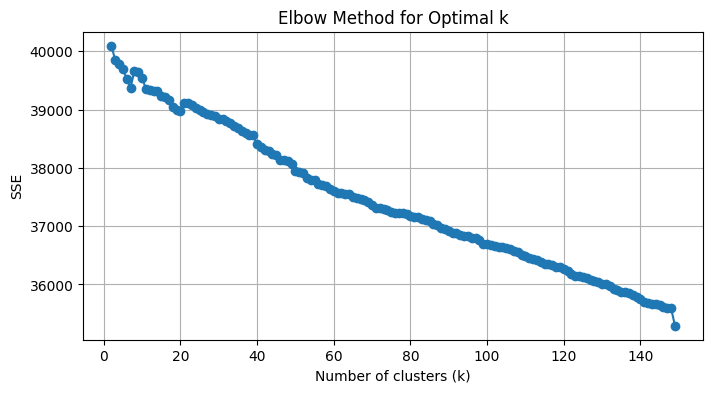

In [ ]:
import pandas as pd
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re

# === 1. 讀取原始資料 ===
input_path = "/mnt/d/Download/91APP_Dataset(會員&主單&子單&商品頁&標籤)/SalePage.csv"
category_df = pd.read_csv(input_path, encoding='ISO-8859-1')

# === 2. 修復 Big5 亂碼 → 正常中文 ===
def fix_encoding(text):
    try:
        return text.encode('ISO-8859-1').decode('big5')
    except:
        return text

category_df['SalePageTitle'] = category_df['SalePageTitle'].astype(str).apply(fix_encoding)
category_df['SaleProductDescShortContent'] = category_df['SaleProductDescShortContent'].astype(str).apply(fix_encoding)

# === 3. 過濾：排除包含以下關鍵字的項目 ===
exclude_keywords = ['贈品', '任選', '洽門市', '刪除','預購','廠商直','系列','限定','限時',
                    '福利品','日本','巧克力','韓國','保濕','噴霧','精華','風味','造型','團購',
                    '迷你','角落','solone','修護','絕不','可選','meko','專業','完眉視角','顏值','覺醒','單支','含蓋','抗菌']
pattern = '|'.join(exclude_keywords)
category_df = category_df[~category_df['SalePageTitle'].str.contains(pattern, na=False)]

# === 4. 去除數字單位（例如：10ml、3入、x5、容量500ml）===
def clean_quantity_units(text):
    text = re.sub(r"\d+(\.\d+)?\s*(ml|g|kg|l|mm|cm|入|片|包|顆|錠|公克|毫升|公斤|公升)", "", text, flags=re.IGNORECASE)
    text = re.sub(r"[xX＊*]\s*\d+", "", text, flags=re.IGNORECASE)  # 移除 x5、X3、＊2 這類標示
    text = re.sub(r"容量\s*\d+(\.\d+)?\s*(ml|g|kg|l|mm|cm)?", "", text, flags=re.IGNORECASE)
    return text.strip()

category_df['CleanedTitle'] = category_df['SalePageTitle'].apply(clean_quantity_units)

# === 5. 中文斷詞 + TF-IDF ===
titles_cut = [" ".join(jieba.cut(t)) for t in category_df['CleanedTitle'].fillna("")]
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5)
X = vectorizer.fit_transform(titles_cut)

# === 6. 肘部法（如需觀察可啟用）===
sse = []
K_range = range(2, 150)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, sse, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

In [ ]:
# === 7. 執行 KMeans 分群 ===
best_k = 150
kmeans = KMeans(n_clusters=best_k, random_state=42)
category_df['category'] = kmeans.fit_predict(X)

# === 8. 儲存為新的 Excel ===
output_path = input_path.replace(".csv", "_with_category.xlsx")
category_df.to_excel(output_path, index=False, engine='openpyxl')
print(f"✅ 已成功輸出結果至：{output_path}")

✅ 已成功輸出結果至：/mnt/d/Download/91APP_Dataset(會員&主單&子單&商品頁&標籤)/SalePage_with_category.xlsx


In [ ]:
print("\n📊 每個類別的商品數量（完整顯示）：")
print(category_df['category'].value_counts().sort_index().to_string())


📊 每個類別的商品數量（完整顯示）：
category
0        105
1          6
2         29
3        140
4        810
5         50
6         95
7         13
8      26388
9        127
10        77
11       329
12        33
13        93
14        33
15        65
16        10
17        65
18        86
19        55
20        39
21        72
22       131
23       426
24       139
25       320
26         6
27        78
28       162
29        97
30        56
31        59
32       158
33        65
34        70
35        78
36        41
37       364
38       118
39       281
40       156
41        57
42       218
43        20
44       224
45        24
46        28
47       113
48       124
49       188
50        31
51       101
52        17
53       199
54       202
55       100
56        23
57        48
58        41
59        24
60       293
61        33
62        55
63       122
64       128
65        39
66        78
67        31
68         9
69        77
70       254
71       256
72        46
73        24
74       

In [ ]:
import numpy as np
# === 先重設索引，以利後續用 index 取 TF-IDF 向量 ===
category_df = category_df.reset_index(drop=True)

# === 取出目標分類 ===
target_category = 8
target_indices = category_df[category_df['category'] == target_category].index.tolist()

# === 累加該分類所有商品的 TF-IDF 權重向量總和 ===
category_tfidf_sum = np.array(X[target_indices].sum(axis=0)).flatten()

# === 取出關鍵詞與對應權重 ===
terms = vectorizer.get_feature_names_out()
tfidf_weights = list(zip(terms, category_tfidf_sum))
top_keywords = sorted(tfidf_weights, key=lambda x: x[1], reverse=True)[:50]

# === 顯示結果 ===
print(f"\n📚 分類 {target_category} 的代表關鍵詞（依 TF-IDF 權重排序）：")
for word, score in top_keywords:
    print(f"{word:<20s} → {score:.4f}")


📚 分類 8 的代表關鍵詞（依 TF-IDF 權重排序）：
面膜                   → 176.2178
咖啡                   → 119.8404
1028                 → 115.6581
珍珠                   → 110.3707
玫瑰                   → 108.1888
唇膏                   → 98.0450
沐浴露                  → 91.3768
30                   → 90.3468
控油                   → 89.0971
毛巾                   → 87.9522
香水                   → 84.2272
原味                   → 81.7304
蠟筆                   → 80.6390
lumina               → 80.3595
雙入                   → 80.0040
天然                   → 79.1398
econeco              → 79.0033
沐浴                   → 76.8963
膠囊                   → 75.9162
經典                   → 75.6927
kinyo                → 74.7687
樂品                   → 74.0058
沐浴乳                  → 73.3024
蜜粉                   → 73.0902
凝膠                   → 72.9843
多功能                  → 72.1980
旅行                   → 72.1568
草莓                   → 72.1145
心機                   → 71.6388
草本                   → 71.0371
黑色                   → 69.5549
乳液 

In [ ]:
# === 載入使用者行為資料 ===
behavior_path = "/mnt/d/Download/91APP_Dataset(session01)/session01_202312.csv"
behavior_df = pd.read_csv(behavior_path, encoding='utf-8-sig')

# === 篩選加入購物車（add to cart）的行為 ===
add_to_cart_df = behavior_df[behavior_df["Behavior"] == "add"]

/tmp/ipykernel_11578/4014310182.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  behavior_df = pd.read_csv(behavior_path, encoding='utf-8-sig')


In [ ]:
add_to_cart_df["SalePageId"] = add_to_cart_df["SalePageId"].astype(int)
category_df["SalePageId"] = category_df["SalePageId"].astype(int)
print(add_to_cart_df["SalePageId"].dtype)
print(category_df["SalePageId"].dtype)

int64
int64


/tmp/ipykernel_11578/1977761497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  add_to_cart_df["SalePageId"] = add_to_cart_df["SalePageId"].astype(int)


In [ ]:
# === 將 category_df 中的 category 欄位依 SalePageId 合併到 add_to_cart_df ===
add_to_cart_df = add_to_cart_df.merge(
    category_df[["SalePageId", "category"]],
    on="SalePageId",
    how="left"
)

In [ ]:
print(add_to_cart_df.columns.tolist())

# 合併前的筆數
print("🧾 合併前筆數：", len(add_to_cart_df))

# 合併後成功對應 category 的筆數
matched_count = add_to_cart_df["category"].notna().sum()
print("✅ 成功對應到分類的筆數：", matched_count)

# 合併後無法對應的筆數
missing_count = add_to_cart_df["category"].isna().sum()
print("⚠️ 無法對應分類的筆數：", missing_count)

# 篩選有對應 category 的資料
matched_df = add_to_cart_df[add_to_cart_df["category"].notna()]

match_path = "/mnt/d/Download/Preprocessing/Session12_add_with_category.csv"
matched_df.to_csv(match_path, index=False, encoding='utf-8-sig')

print(f"✅ 已成功匯出有對應 category 的資料至：{match_path}")

['Tunnel', 'Device', 'ShopId', 'ShopMemberId', 'FullvisitorId', 'DeviceId', 'HitTime', 'Language', 'CountryAliasCode', 'Version', 'UTMSource', 'UTMMedium', 'UTMName', 'Behavior', 'RegisterTunnel', 'CategoryId', 'SalePageId', 'UnitPrice', 'Qty', 'TotalSalesAmount', 'CurrencyCode', 'TradesGroupCode', 'SearchTerm', 'ContentType', 'ContentName', 'ContentId', 'PageType', 'EventTime', 'category']
🧾 合併前筆數： 580010
✅ 成功對應到分類的筆數： 272973
⚠️ 無法對應分類的筆數： 307037
✅ 已成功匯出有對應 category 的資料至：/mnt/d/Download/Preprocessing/Session12_add_with_category.csv


In [ ]:
import pandas as pd
import glob
import os

# 設定資料夾路徑
behavior_path = "/mnt/d/Download/Preprocessing/"

# 找出所有符合的 CSV 檔案
csv_files = glob.glob(os.path.join(behavior_path, "Session*.csv"))

# 確認找到的檔案清單
print("找到的檔案：", csv_files)

# 讀取並合併所有檔案
add_to_cart_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# 顯示總筆數與欄位資訊
print("總筆數：", len(add_to_cart_df))
print("欄位：", add_to_cart_df.columns.tolist())


找到的檔案： ['/mnt/d/Download/Preprocessing/Session09_add_with_category.csv', '/mnt/d/Download/Preprocessing/Session10_add_with_category.csv', '/mnt/d/Download/Preprocessing/Session11_add_with_category.csv', '/mnt/d/Download/Preprocessing/Session12_add_with_category.csv']
總筆數： 1236664
欄位： ['Tunnel', 'Device', 'ShopId', 'ShopMemberId', 'FullvisitorId', 'DeviceId', 'HitTime', 'Language', 'CountryAliasCode', 'Version', 'UTMSource', 'UTMMedium', 'UTMName', 'Behavior', 'RegisterTunnel', 'CategoryId', 'SalePageId', 'UnitPrice', 'Qty', 'TotalSalesAmount', 'CurrencyCode', 'TradesGroupCode', 'SearchTerm', 'ContentType', 'ContentName', 'ContentId', 'PageType', 'EventTime', 'category']


In [ ]:
add_to_cart_df["SessionId"] = add_to_cart_df["FullvisitorId"].astype(str) + "_" + add_to_cart_df["HitTime"].astype(str)
basket_df = add_to_cart_df.groupby("SessionId")["category"].apply(set).reset_index(name="cluster_basket")

In [ ]:
# 這段程式的目的是統計哪些「分類」常常一起被加入購物車。
from itertools import combinations
from collections import defaultdict

co_matrix = defaultdict(int)

for clusters in basket_df["cluster_basket"]:
    for c1, c2 in combinations(sorted(clusters), 2):
        co_matrix[(c1, c2)] += 1

In [ ]:
# 將結果轉成 DataFrame 方便查看
co_df = pd.DataFrame([
    {"Category1": k[0], "Category2": k[1], "Count": v}
    for k, v in co_matrix.items()
])

# 移除重複的對角線項目（可選）
co_df = co_df[co_df["Category1"] != co_df["Category2"]]

# 依共現次數排序
co_df = co_df.sort_values(by="Count", ascending=False)

# 顯示前幾筆共現結果
print(co_df.head(10))

    Category1  Category2  Count
9        72.0        2.0  12933
8         2.0       72.0  12933
5        37.0       72.0   5391
4        72.0       37.0   5391
0         2.0       37.0   4471
1        37.0        2.0   4471
12        2.0       67.0   2475
13       67.0        2.0   2475
16        2.0       78.0   2354
17       78.0        2.0   2354


In [ ]:
from itertools import combinations
from collections import defaultdict
import pandas as pd

# 假設你已有 basket_df["cluster_basket"]，其內容為每個 SessionId 的商品類別集合
# 範例：basket_df["cluster_basket"] = [{"A", "B", "C"}, {"A", "C"}, {"B", "D"}, ...]

# === 1. 建立共現矩陣（排除 nan） ===
co_matrix = defaultdict(int)

for clusters in basket_df["cluster_basket"]:
    clean_clusters = [c for c in clusters if pd.notnull(c)]
    for c1, c2 in combinations(clean_clusters, 2):
        co_matrix[(c1, c2)] += 1
        co_matrix[(c2, c1)] += 1  # 雙向計數

# === 2. 建立推薦字典，並排序取得 Top-N 候選 ===
recommend_dict = defaultdict(list)
for (c1, c2), count in co_matrix.items():
    if pd.notnull(c1) and pd.notnull(c2):
        recommend_dict[c1].append((c2, count))

# 依共現次數排序
for c1 in recommend_dict:
    recommend_dict[c1] = sorted(recommend_dict[c1], key=lambda x: x[1], reverse=True)

# === 3. 顯示每個類別的 Top-N 推薦 ===
top_n = 5
print(f"📊 Top-{top_n} 類別共現推薦：")

for c1 in sorted(recommend_dict.keys()):
    print(f"\n🟢 分類 {c1} 的推薦類別：")
    for rank, (c2, count) in enumerate(recommend_dict[c1][:top_n], 1):
        print(f"  {rank}. 類別 {c2}（共現次數：{count}）")

📊 Top-5 類別共現推薦：

🟢 分類 0.0 的推薦類別：
  1. 類別 8.0（共現次數：21）
  2. 類別 25.0（共現次數：4）
  3. 類別 37.0（共現次數：3）
  4. 類別 129.0（共現次數：2）
  5. 類別 32.0（共現次數：2）

🟢 分類 3.0 的推薦類別：
  1. 類別 8.0（共現次數：52）
  2. 類別 129.0（共現次數：11）
  3. 類別 37.0（共現次數：10）
  4. 類別 25.0（共現次數：5）
  5. 類別 81.0（共現次數：4）

🟢 分類 4.0 的推薦類別：
  1. 類別 8.0（共現次數：758）
  2. 類別 25.0（共現次數：55）
  3. 類別 24.0（共現次數：50）
  4. 類別 15.0（共現次數：40）
  5. 類別 37.0（共現次數：17）

🟢 分類 6.0 的推薦類別：
  1. 類別 8.0（共現次數：6）
  2. 類別 22.0（共現次數：1）
  3. 類別 86.0（共現次數：1）
  4. 類別 124.0（共現次數：1）
  5. 類別 65.0（共現次數：1）

🟢 分類 7.0 的推薦類別：
  1. 類別 71.0（共現次數：1）
  2. 類別 8.0（共現次數：1）
  3. 類別 44.0（共現次數：1）
  4. 類別 112.0（共現次數：1）

🟢 分類 8.0 的推薦類別：
  1. 類別 80.0（共現次數：55991）
  2. 類別 48.0（共現次數：11063）
  3. 類別 25.0（共現次數：7347）
  4. 類別 15.0（共現次數：6301）
  5. 類別 24.0（共現次數：4172）

🟢 分類 9.0 的推薦類別：
  1. 類別 8.0（共現次數：14）
  2. 類別 37.0（共現次數：4）
  3. 類別 129.0（共現次數：2）
  4. 類別 66.0（共現次數：1）
  5. 類別 71.0（共現次數：1）

🟢 分類 10.0 的推薦類別：
  1. 類別 8.0（共現次數：7）
  2. 類別 71.0（共現次數：3）
  3. 類別 106.0（共現次數：1）
  4. 類別 84.0（共現次數：1）
  5. 類別 77.0（共現次數：1）



In [ ]:
top_n = 15
recommend_top_df = pd.DataFrame([
    {"Category": c1, "Recommended": c2, "CoOccurrence": count}
    for c1, recs in recommend_dict.items()
    for c2, count in recs[:top_n]
])
print(recommend_top_df.head())

recommend202310_topN = "/mnt/d/Download/preprocessing/recommend202309~12_topN.csv"
recommend_top_df.to_csv(recommend202310_topN, index=False, encoding="utf-8-sig")

   Category  Recommended  CoOccurrence
0      80.0          8.0         55991
1      80.0         48.0         10756
2      80.0         68.0           502
3      80.0         39.0           148
4       8.0         80.0         55991


In [ ]:
def recommend_clusters(current_clusters, recommend_dict, top_n=3):
    scores = defaultdict(int)
    for c in current_clusters:
        for rec_c, weight in recommend_dict.get(c, []):
            if rec_c not in current_clusters:
                scores[rec_c] += weight
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]


In [ ]:
# 🛒 購物車中的 SalePageId 列表
cart_items = [9041268]  # 你實際的購物車商品ID

# 從 add_to_cart_df 找出這些商品對應的分類（注意要去除重複）
current_clusters = (
    add_to_cart_df[add_to_cart_df["SalePageId"].isin(cart_items)]["category"]
    .dropna()
    .unique()
    .tolist()
)

# 呼叫推薦函數
recommend_result = recommend_clusters(current_clusters, recommend_dict, top_n=3)

# 顯示推薦分類
print("當購物車中包含商品 ID：", cart_items)
print("對應分類為：", current_clusters)
print("推薦的分類為：")
for category, score in recommend_result:
    print(f"分類 {category}（共現強度：{score}）")

當購物車中包含商品 ID： [9041268]
對應分類為： [8.0]
推薦的分類為：
分類 80.0（共現強度：55991）
分類 48.0（共現強度：11063）
分類 25.0（共現強度：7347）


In [ ]:
# 從推薦分類中選出商品
recommended_items = []

for category, _ in recommend_result:
    items_in_category = category_df[category_df["category"] == category]

    # 選前幾個商品（這裡取前 3 個）
    top_items = items_in_category.head(3)

    for _, row in top_items.iterrows():
        recommended_items.append({
            "category": category,
            "SalePageId": row["SalePageId"],
            "SalePageTitle": row.get("SalePageTitle", "N/A")
        })

In [ ]:
# 從 category_df 找出購物車中商品的名稱
cart_titles = (
    category_df[category_df["SalePageId"].isin(cart_items)][["SalePageId", "SalePageTitle"]]
    .drop_duplicates()
    .to_dict(orient="records")
)

# 顯示購物車商品 ID 與名稱
print("當購物車中包含商品 ID：", cart_items)
print("對應的商品名稱為：")
for item in cart_titles:
    print(f"商品 {item['SalePageId']}：{item['SalePageTitle']}")

# 從 add_to_cart_df 找出這些商品對應的分類（注意要去除重複）
current_clusters = (
    add_to_cart_df[add_to_cart_df["SalePageId"].isin(cart_items)]["category"]
    .dropna()
    .unique()
    .tolist()
)

# 顯示分類
print("對應分類為：", current_clusters)

# 呼叫推薦函數
recommend_result = recommend_clusters(current_clusters, recommend_dict, top_n=3)

# 顯示推薦分類
print("推薦的分類為：")
for category, score in recommend_result:
    print(f"分類 {category}（共現強度：{score}）")

# 從推薦分類中選出商品
recommended_items = []

for category, _ in recommend_result:
    items_in_category = category_df[category_df["category"] == category]

    # 選前幾個商品（這裡取前 3 個）
    top_items = items_in_category.head(3)

    for _, row in top_items.iterrows():
        recommended_items.append({
            "category": category,
            "SalePageId": row["SalePageId"],
            "SalePageTitle": row["SalePageTitle"]  # 保證一定顯示 title，不使用 .get
        })

# 顯示推薦商品
print("推薦商品如下：")
for item in recommended_items:
    print(f"分類 {item['category']} - 商品 {item['SalePageId']}：{item['SalePageTitle']}")

當購物車中包含商品 ID： [9041268]
對應的商品名稱為：
商品 9041268：舒緩安敏原生露【穩膚乖乖露】
對應分類為： [8.0]
推薦的分類為：
分類 80.0（共現強度：55991）
分類 48.0（共現強度：11063）
分類 25.0（共現強度：7347）
推薦商品如下：
分類 80.0 - 商品 8833872：TopOn酵母葡聚醣褐藻醣膠膠囊30粒
分類 80.0 - 商品 7534172：76酵母胺基酸淨膚潔顏露-30G隨身瓶
分類 80.0 - 商品 9091208：【滿額贈】滿$3880【送】76酵母胺基酸淨膚潔顏露-30ML隨身瓶
分類 48.0 - 商品 7433195：MEKO中圓粉刺夾
分類 48.0 - 商品 7433197：KRONEN優質粉刺夾_直
分類 48.0 - 商品 7433198：KRONEN勾粉刺夾_刮棒勾
分類 25.0 - 商品 7427347：紀陽除蟲菊-日製防黴洗衣槽清潔劑100g
分類 25.0 - 商品 7427424：P&G_Ariel新3室內晾衣專用3D洗衣膠球16P補
分類 25.0 - 商品 7427405：P&G_Ariel_BIO微香潔淨3D洗衣膠球16P本
